# Script to calculate relationship between Water content and Reflectance

In [131]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import math

# RTC

## Import reflectance & weight data

In [132]:
###### ADD leaf water content file ######

refl_data = pd.read_csv("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/01_merged_reflectance_rtc/rtc_merged_refl.csv")

# Read the CSV, skipping the first 4 rows (adjust if needed)
lwc = pd.read_csv(
    "/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/leaf_water_content.csv",
    header = None)

In [133]:
# Extract leaf_kind as the last suffix after '_' in the basename (before .las)
refl_data["leaf_kind"] = refl_data["filename"].apply(
    lambda x: os.path.basename(x).rsplit('_', 1)[-1].replace('.las', '').lower()
)

As we have issues with the format of the excel sheet - we assign names to the columns manually 


In [134]:

# The file has 11 columns, so set 11 column names
lwc.columns = [
    'leaf_kind', 'mes1', "mes2", "mes3"
]

lwc["leaf_kind"] = lwc["leaf_kind"].str.lower().str.replace(" ", "")

leaf_kind_mapping = {
    "lindei": "linde1",
    "lindeii": "linde2",
    "lindeiii": "linde3",
    "klein": "ahorn-klein",
    "gross": "ahorn-gross",
    "ahorngroß": "ahorn-gross",
    "ahorn_groß": "ahorn-gross",
    "ahorngross": "ahorn-gross",
    "ahornxxl": "ahorn-xxl",
    "ahornklein": "ahorn-klein",
    "ahorn_gross": "ahorn-gross",
    "ahorn_xxl": "ahorn-xxl",
    "ahron_klein": "ahorn-klein",
    "ahorn_klein": "ahorn-klein"
}

In [135]:
# Map the dictionary to the leaf_kinds
refl_data["leaf_kind"] = refl_data["leaf_kind"].replace(leaf_kind_mapping)
lwc["leaf_kind"] = lwc["leaf_kind"].replace(leaf_kind_mapping)

In [136]:
# Merge refl_data and lwc on leaf_kind
merged = pd.merge(refl_data, lwc, on="leaf_kind", how="left")

In [137]:
# Match the mes1/2/3 columns from lwc to measurement 1/2/3 and leaf_kind

# First, create a mapping from (leaf_kind, measurement) to the correct mes column
def get_lwc_value(row):
    meas = int(row['measurement'])
    col = f'mes{meas}'
    # Find the lwc row matching the leaf_kind
    lwc_row = lwc[lwc['leaf_kind'] == row['leaf_kind']]
    if not lwc_row.empty and col in lwc_row.columns:
        return lwc_row.iloc[0][col]
    else:
        return None

# Add the water content value from lwc to merged
merged['wc'] = merged.apply(get_lwc_value, axis=1)


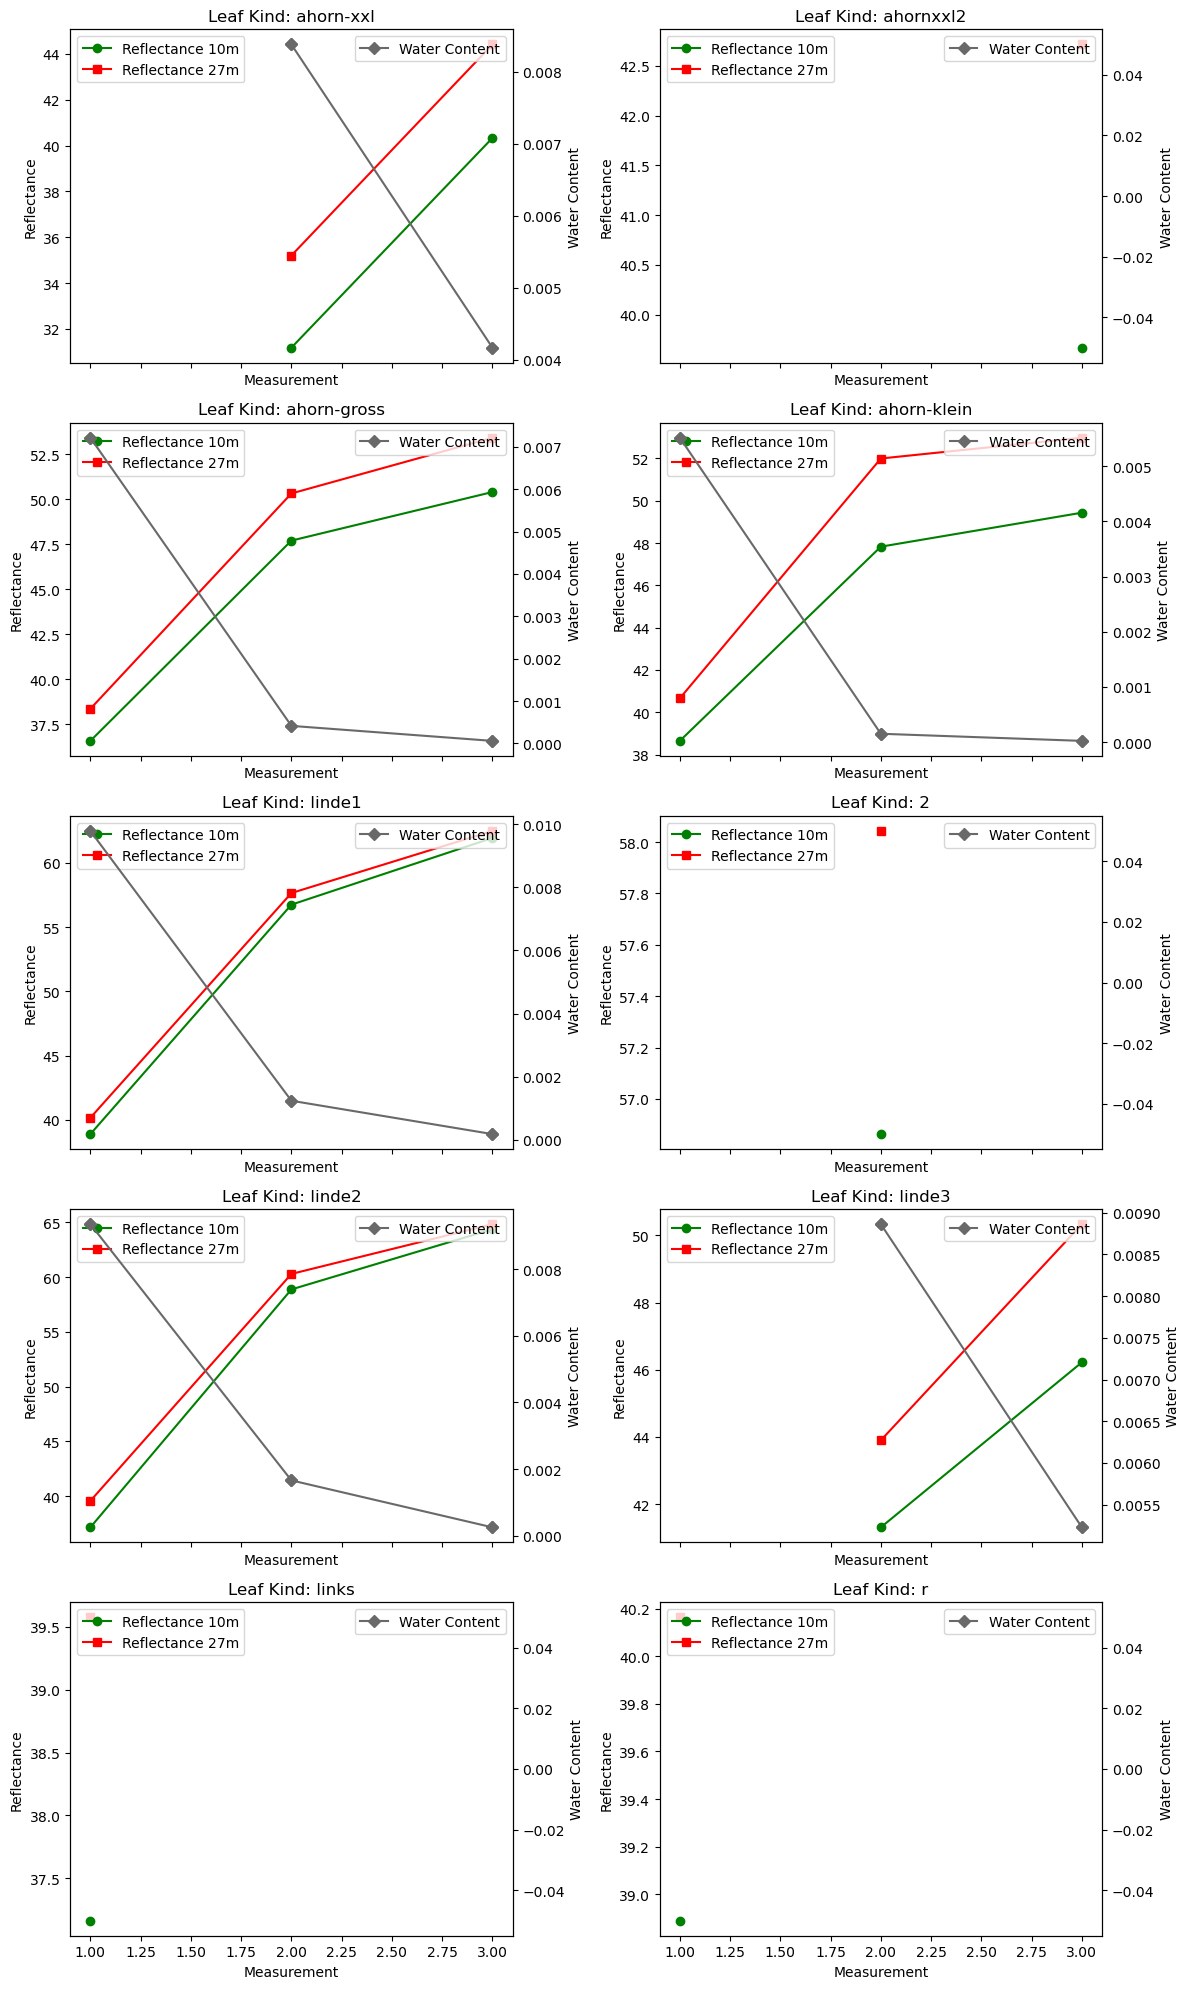

In [138]:
merged_valid = merged[merged.groupby('leaf_kind')['measurement'].transform('count') >= 4]

merged_valid.to_csv("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/rtc_refl_wc.csv")

leaf_kinds = merged['leaf_kind'].unique()
distances = merged['distance'].unique() if 'distance' in merged.columns else ['10m', '27m']
colors = {'10m': 'g', '27m': 'r'}
markers = {'10m': 'o', '27m': 's'}

ncols = 2
nrows = (len(leaf_kinds) + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharex=True)
axes = axes.flatten()

for ax, leaf in zip(axes, leaf_kinds):
    data = merged[merged['leaf_kind'] == leaf]
    ax2 = ax.twinx()
    for dist in distances:
        sub = data[data['distance'] == dist] if 'distance' in data.columns else data
        if not sub.empty:
            ax.plot(sub['measurement'], sub['mean_intensity_corr'], color=colors.get(dist, 'b'), marker=markers.get(dist, 'o'), label=f'Reflectance {dist}')
    # Plot water content as a single dark grey line (not grouped by distance)
    ax2.plot(data['measurement'], data['wc'], color='dimgray', marker='D', linestyle='-', label='Water Content')
    ax.set_title(f'Leaf Kind: {leaf}')
    ax.set_ylabel('Reflectance')
    ax2.set_ylabel('Water Content')
    ax.set_xlabel('Measurement')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for i in range(len(leaf_kinds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/rtc_refl_wc_impression.png", dpi='figure', format=None)
plt.show()


# ABS

In [139]:
abs_data = pd.read_csv("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/00_processed_abs/abs_x_max.csv")

abs_data["leaf_kind"] = abs_data["basename"].apply(
    lambda x: '_'.join(os.path.basename(x).split('_')[3:5]).replace('.las', '').lower().replace("_ir", ""))

abs_data.rename(
    columns={"x_max": "abs_refl"},
    inplace=True
)


In [140]:

abs_data["leaf_kind"] = abs_data["leaf_kind"].replace(leaf_kind_mapping)

abs_rtc_merged = pd.merge(
    merged_valid,
    abs_data,
    on=["leaf_kind", "distance", "measurement"],
    how="left"
)

In [141]:
# now calculate a ratio out of abs and rtc reflectances

abs_rtc_merged["rtc/abs_mean"] = abs_rtc_merged["mean_intensity_corr"] / abs_rtc_merged["abs_refl"]
abs_rtc_merged["abs/rtc_mean"] = abs_rtc_merged["abs_refl"] / abs_rtc_merged["mean_intensity_corr"]

# Calculate the ratios for median-values
abs_rtc_merged["rtc/abs_median"] = abs_rtc_merged["median_intensity_corr"] / abs_rtc_merged["abs_refl"]
abs_rtc_merged["abs/rtc_median"] = abs_rtc_merged["abs_refl"] / abs_rtc_merged["median_intensity_corr"]



### Visual Inspection of Wavelengths vs Leaf Water content

#### MEAN RTC Intensity

##### RTC / ABS

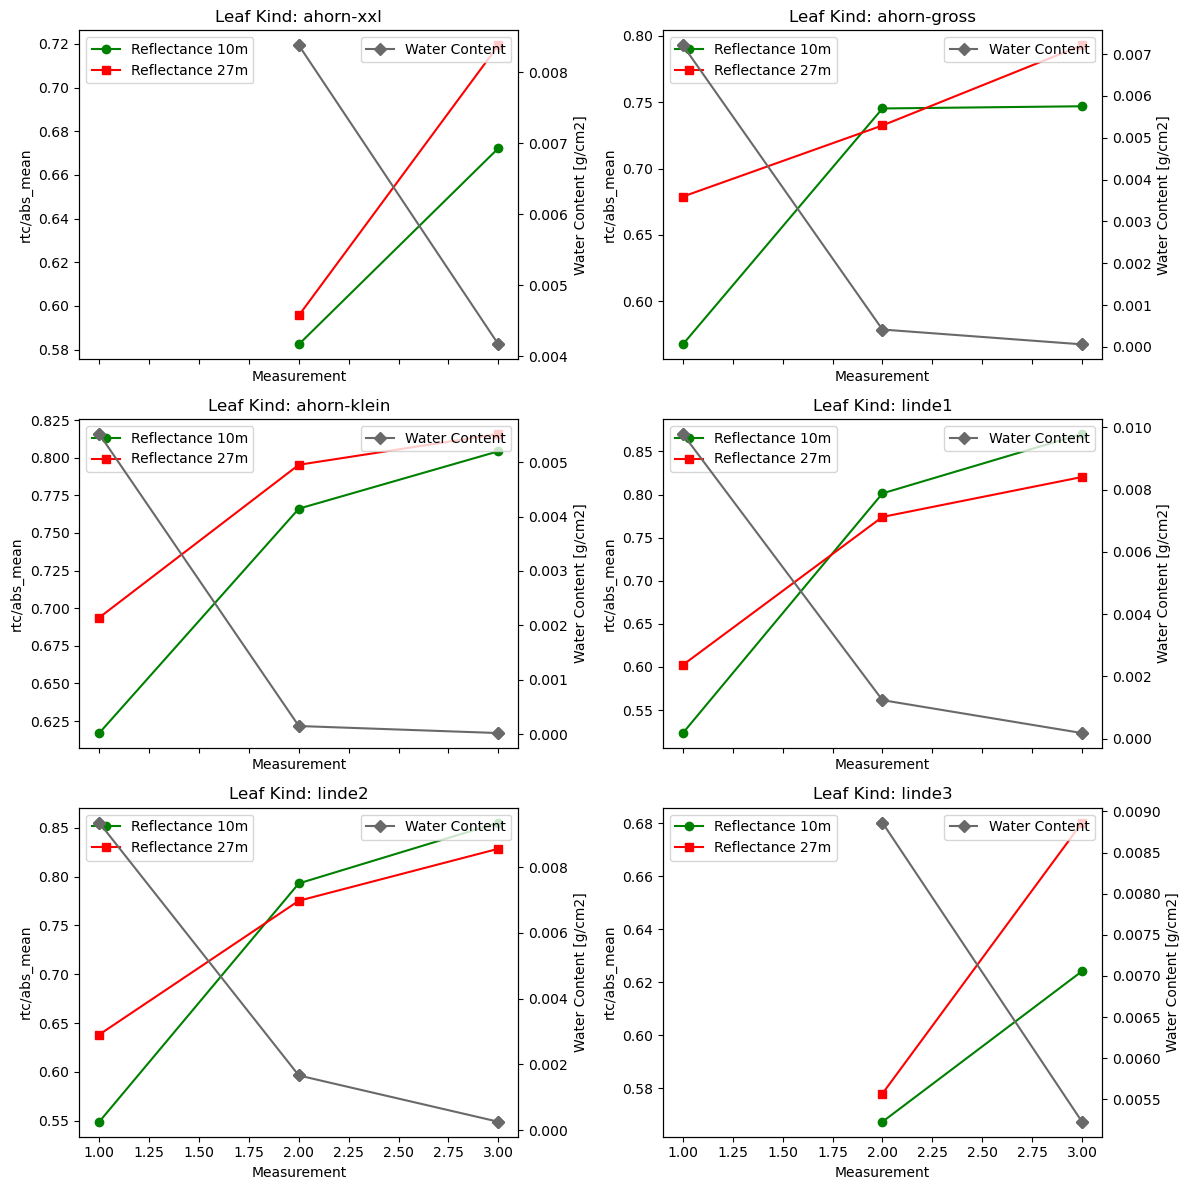

In [142]:
leaf_kinds = abs_rtc_merged['leaf_kind'].unique()
distances = abs_rtc_merged['distance'].unique() if 'distance' in abs_rtc_merged.columns else ['10m', '27m']
colors = {'10m': 'g', '27m': 'r'}
markers = {'10m': 'o', '27m': 's'}

ncols = 2
nrows = (len(leaf_kinds) + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharex=True)
axes = axes.flatten()

for ax, leaf in zip(axes, leaf_kinds):
    data = abs_rtc_merged[abs_rtc_merged['leaf_kind'] == leaf]
    ax2 = ax.twinx()
    for dist in distances:
        sub = data[data['distance'] == dist] if 'distance' in data.columns else data
        if not sub.empty:
            ax.plot(sub['measurement'], sub['rtc/abs_mean'], color=colors.get(dist, 'b'), marker=markers.get(dist, 'o'), label=f'Reflectance {dist}')
    # Plot water content as a single dark grey line (not grouped by distance)
    ax2.plot(data['measurement'], data['wc'], color='dimgray', marker='D', linestyle='-', label='Water Content')
    ax.set_title(f'Leaf Kind: {leaf}')
    ax.set_ylabel('rtc/abs_mean')
    ax2.set_ylabel('Water Content [g/cm2]')
    ax.set_xlabel('Measurement')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for i in range(len(leaf_kinds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/rtc_abs_mean_wc_impression.png", dpi='figure', format=None)
plt.show()

##### ABS/RTC

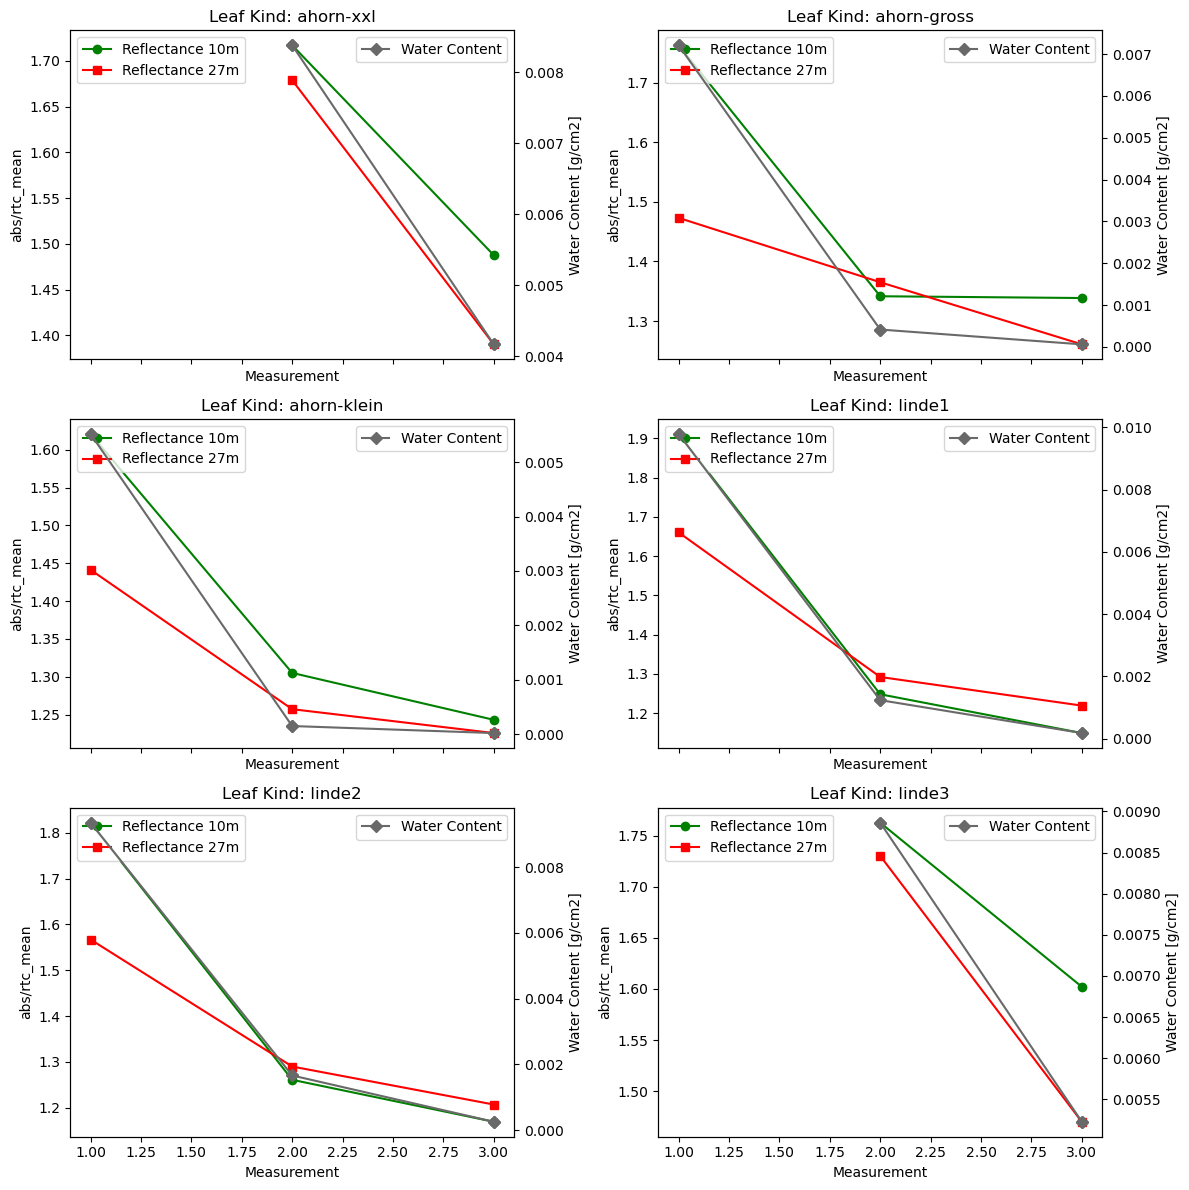

In [143]:
leaf_kinds = abs_rtc_merged['leaf_kind'].unique()
# distances = abs_rtc_merged['distance'].unique() if 'distance' in abs_rtc_merged.columns else ['10m', '27m']
distances = abs_rtc_merged['distance'].unique() if 'distance' in abs_rtc_merged.columns else ['10m']

colors = {'10m': 'g', '27m': 'r'}
markers = {'10m': 'o', '27m': 's'}

ncols = 2
nrows = (len(leaf_kinds) + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharex=True)
axes = axes.flatten()

for ax, leaf in zip(axes, leaf_kinds):
    data = abs_rtc_merged[abs_rtc_merged['leaf_kind'] == leaf]
    ax2 = ax.twinx()
    for dist in distances:
        sub = data[data['distance'] == dist] if 'distance' in data.columns else data
        if not sub.empty:
            ax.plot(sub['measurement'], sub['abs/rtc_mean'], color=colors.get(dist, 'b'), marker=markers.get(dist, 'o'), label=f'Reflectance {dist}')
    # Plot water content as a single dark grey line (not grouped by distance)
    ax2.plot(data['measurement'], data['wc'], color='dimgray', marker='D', linestyle='-', label='Water Content')
    ax.set_title(f'Leaf Kind: {leaf}')
    ax.set_ylabel('abs/rtc_mean')
    ax2.set_ylabel('Water Content [g/cm2]')
    ax.set_xlabel('Measurement')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for i in range(len(leaf_kinds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/abs_rtc_mean_wc_impression.png", dpi='figure', format=None)
plt.show()

In the next step we want to find out, whether we can use the two wavelengths to say something about the 

#### MEDIAN RTC
##### RTC / ABS

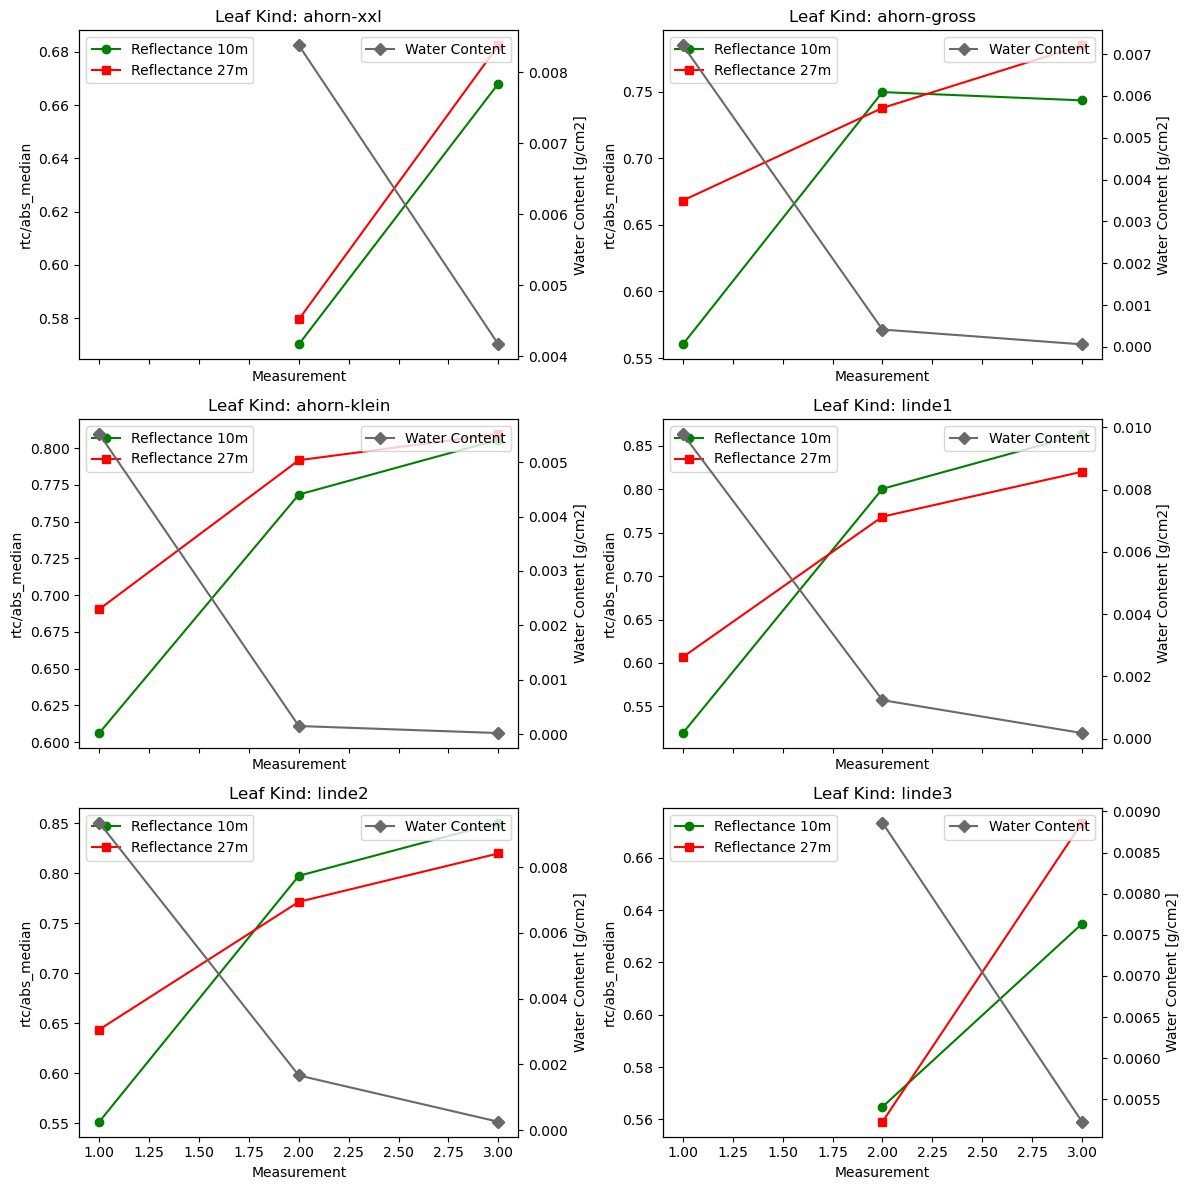

In [144]:
leaf_kinds = abs_rtc_merged['leaf_kind'].unique()
distances = abs_rtc_merged['distance'].unique() if 'distance' in abs_rtc_merged.columns else ['10m', '27m']
colors = {'10m': 'g', '27m': 'r'}
markers = {'10m': 'o', '27m': 's'}

ncols = 2
nrows = (len(leaf_kinds) + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharex=True)
axes = axes.flatten()

for ax, leaf in zip(axes, leaf_kinds):
    data = abs_rtc_merged[abs_rtc_merged['leaf_kind'] == leaf]
    ax2 = ax.twinx()
    for dist in distances:
        sub = data[data['distance'] == dist] if 'distance' in data.columns else data
        if not sub.empty:
            ax.plot(sub['measurement'], sub['rtc/abs_median'], color=colors.get(dist, 'b'), marker=markers.get(dist, 'o'), label=f'Reflectance {dist}')
    # Plot water content as a single dark grey line (not grouped by distance)
    ax2.plot(data['measurement'], data['wc'], color='dimgray', marker='D', linestyle='-', label='Water Content')
    ax.set_title(f'Leaf Kind: {leaf}')
    ax.set_ylabel('rtc/abs_median')
    ax2.set_ylabel('Water Content [g/cm2]')
    ax.set_xlabel('Measurement')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for i in range(len(leaf_kinds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/rtc_abs_median_wc_impression.png", dpi='figure', format=None)
plt.show()

##### ABS/RTC

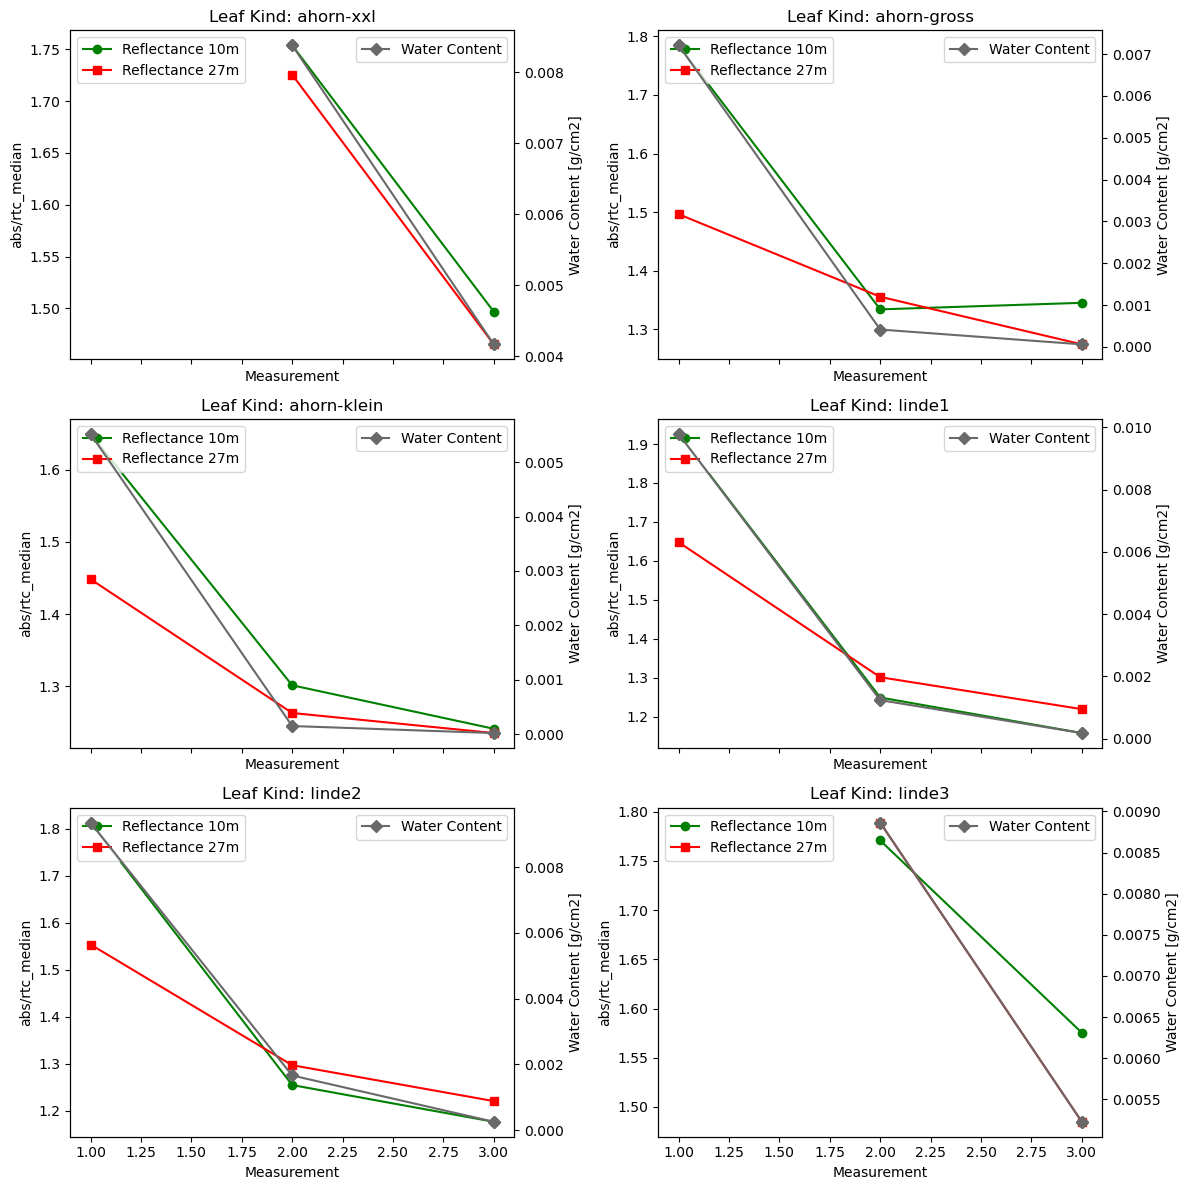

In [145]:
leaf_kinds = abs_rtc_merged['leaf_kind'].unique()
distances = abs_rtc_merged['distance'].unique() if 'distance' in abs_rtc_merged.columns else ['10m', '27m']
colors = {'10m': 'g', '27m': 'r'}
markers = {'10m': 'o', '27m': 's'}

ncols = 2
nrows = (len(leaf_kinds) + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows), sharex=True)
axes = axes.flatten()

for ax, leaf in zip(axes, leaf_kinds):
    data = abs_rtc_merged[abs_rtc_merged['leaf_kind'] == leaf]
    ax2 = ax.twinx()
    for dist in distances:
        sub = data[data['distance'] == dist] if 'distance' in data.columns else data
        if not sub.empty:
            ax.plot(sub['measurement'], sub['abs/rtc_median'], color=colors.get(dist, 'b'), marker=markers.get(dist, 'o'), label=f'Reflectance {dist}')
    # Plot water content as a single dark grey line (not grouped by distance)
    ax2.plot(data['measurement'], data['wc'], color='dimgray', marker='D', linestyle='-', label='Water Content')
    ax.set_title(f'Leaf Kind: {leaf}')
    ax.set_ylabel('abs/rtc_median')
    ax2.set_ylabel('Water Content [g/cm2]')
    ax.set_xlabel('Measurement')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for i in range(len(leaf_kinds), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/abs_rtc_median_wc_impression.png", dpi='figure', format=None)
plt.show()

In [127]:
# save a subset of the merged_table, only for front/back comparison
subset_front_back_comparison = abs_rtc_merged[
    (abs_rtc_merged["leaf_kind"].isin(["linde1", "linde2", "ahorn-gross", "ahorn-klein"])) &
    (abs_rtc_merged["measurement"] == 1) &
    (abs_rtc_merged["distance"] == "10m")
]

subset_front_back_comparison.to_csv("/mnt/c/Users/Kilian/Documents/LeafH2O/measurements/250522/results/02_merged_reflectance_weight/M1_front_merged.csv")

In [126]:
print(subset_front_back_comparison)

                                             filename  measurement distance  \
5   measurements/250522/leaves/ahorn_gross/1Mes_10...            1      10m   
10  measurements/250522/leaves/ahorn_klein/1Meas_1...            1      10m   
17  measurements/250522/leaves/linde1/1Mes_10m_lea...            1      10m   
23  measurements/250522/leaves/linde2/1Mes_10m_lea...            1      10m   

    mean_intensity_corr  median_intensity_corr    leaf_kind      mes1  \
5             36.578866              36.120392  ahorn-gross  0.007212   
10            38.647420              37.970886  ahorn-klein  0.005516   
17            38.889956              38.587719       linde1  0.009782   
23            37.163750              37.354057       linde2  0.009350   

        mes2      mes3        wc                       basename   abs_refl  \
5   0.000416  0.000062  0.007212  M1_ABS_10m_Ahorn_gross_IR.las  64.470064   
10  0.000153  0.000023  0.005516  M1_ABS_10m_Ahorn_klein_IR.las  62.633530   
17  

### Evaluation

# Model fitting